This notebook aims to study the vulnerabilities and how their fixes relate to backported updates. 

The data we relied on are subject to a non-disclosure agreement. That means we are not allowed to share these data, so you'll have to trust us ;)

In [2]:
import pandas
import numpy as np
import matplotlib
import seaborn

from IPython.display import display

%matplotlib inline

In [3]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (8, 2.5)

ECOSYSTEMS = ['NPM', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2015-01-01'), pandas.to_datetime('2020-01-01')
CENSOR_DATE = pandas.to_datetime('2020-01-12')

PALETTE = seaborn.color_palette()
PAL_REL = np.take(seaborn.color_palette('muted'), [3, 8, 2, 0], axis=0)
COLORS = {'NPM': PALETTE[1], 'Rubygems': PALETTE[3]}

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

# Dataset

In [5]:
df_vuln = (
    pandas.read_csv('../data-raw/all_vulnerabilities.csv', index_col=0, infer_datetime_format=True, parse_dates=['published', 'disclosed'])
    .rename(columns={
        'Id': 'id',
        'vuln_name': 'vulnerability', 
        'base': 'ecosystem', 
        'cvssScore': 'score',
        'fixedIn': 'fix', 
        'affecting': 'affect',
    })
    .replace({'ecosystem': {'npm': 'NPM', 'RubyGems': 'Rubygems'}})
)



In [6]:
print(len(df_vuln[['id','ecosystem']].drop_duplicates()))
df_vuln[['id','ecosystem']].drop_duplicates().groupby('ecosystem').count()

2874


,id
ecosystem,
NPM,2188
Rubygems,686


In [7]:
print(len(df_vuln[['package','ecosystem']].drop_duplicates()))
df_vuln[['package','ecosystem']].drop_duplicates().groupby('ecosystem').count()

2034


,package
ecosystem,
NPM,1700
Rubygems,334


## Data selection

Not all vulnerabilities are of interest for our work. 
First, only the ones affecting one of the packages we considered are useful. Second, only the ones that are fixed are interesting to study (indeed, there is no hope to find a backported fix if there is no fix!). 

In [8]:
df_required = dict()
df_dependents = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. required packages')
    df_required[ecosystem] = (
        pandas.read_csv(
            '../data/{}-required.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )
    
    print('.. dependent packages')
    df_dependents[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependents.csv.gz'.format(ecosystem),
        )
    )
print('Merging...')

df_required = pandas.concat([v.assign(ecosystem=k) for k,v in df_required.items()])
df_dependents = pandas.concat([v.assign(ecosystem=k) for k,v in df_dependents.items()])

print('Done!')

Loading NPM
.. required packages
.. dependent packages
Loading Rubygems
.. required packages
.. dependent packages
Merging...
Done!


In [9]:
df_vuln = (
    df_vuln
    .merge(
        df_required[['ecosystem', 'package']]
        .drop_duplicates()
        .assign(required=True),
        how='left',
        on=['ecosystem', 'package'],
    )
    .fillna({'required': False})
    .assign(fixed=lambda d: ~d['fix'].isin(['undefined']))
)

In [10]:
(
    df_vuln
    .groupby(['ecosystem', 'required', 'fixed'])
    .agg({'vulnerability': 'count'})
)

vulnerability
ecosystem required fixed               
NPM       False    False           1022
                   True             505
          True     False             47
                   True             614
Rubygems  False    False            110
                   True             247
          True     False             14
                   True             315

### We'll focus on the ones being "required" and "fixed". 

In [11]:
df_vuln = df_vuln.query('required and fixed')

In [12]:
df_vuln.id.unique().size, df_vuln.package.unique().size

(929, 412)

In [13]:
df_vuln[['id','ecosystem']].drop_duplicates().groupby('ecosystem').count()

,id
ecosystem,
NPM,614
Rubygems,315


In [14]:
df_vuln[['package','ecosystem']].drop_duplicates().groupby('ecosystem').count()

,package
ecosystem,
NPM,317
Rubygems,97


## Preprocessing

The dataset contains expressions to capture which versions are affected, and in which versions a vulnerability was fixed. 
We'll parse these expressions to convert them to intervals, so we can manipulate them more easily. 
The notation used is close to the one of Packagist, so we'll use our Packagist parser.

In [15]:
import sys

sys.path.append('../data')

from parsers import parse_or_empty, PackagistParser
from version import Version

parser = PackagistParser()

intervals = dict()

for expr in df_vuln.affect.drop_duplicates():
    intervals[expr] = parse_or_empty(parser, expr)
    
for expr in df_vuln.fix.drop_duplicates():
    intervals[expr] = parse_or_empty(parser, expr)

#### How many expressions did we successfully convert?

In [16]:
print('expressions:', len(intervals))
print('converted to non-empty:', len([k for k,v in intervals.items() if not v.empty]))
print('proportion:', len([k for k,v in intervals.items() if not v.empty]) / len(intervals))

print()

print('converted to empty:', len([k for k,v in intervals.items() if v.empty]))
print('\n'.join([k for k,v in intervals.items() if v.empty]))

expressions: 1311
converted to non-empty: 1301
proportion: 0.992372234935164

converted to empty: 10
>=3.0.0-alpha.1 <3.0.0
>=10.0.0-alpha.0 <10.0.0-beta.1
>=3.0.0-rc1 <3.0.0
>=2.0.0-alpha <2.0.0-alpha8
<0.0.0
>=4.0.0-alpha, <4.0.0-beta.2
>=5.2.2, <5.2.2.1
>=4.2.11, <4.2.11.1||>=5.0.7, <5.0.7.2||>=5.1.6, <5.1.6.2||>=5.2.2, <5.2.2.1
< 1.1.rc
1.1.rc


#### We label each release as being "affected" or not.

In [17]:
df_affected = (
    df_required
    .merge(
        df_vuln[['id', 'ecosystem', 'package', 'affect', 'fix']],
        how='inner',
        on=['ecosystem', 'package'],
    )
    # Ignore those for which we cannot deduce a fixed or affected release
    [lambda d: ~d['affect'].isin([k for k,v in intervals.items() if v.empty])]
    [lambda d: ~d['fix'].isin([k for k,v in intervals.items() if v.empty])]
    # Tag releases as fixed or affected
    .assign(affected=lambda d: 
        d.apply(axis=1, func=lambda s: 
            Version.from_string(s.version) in intervals[s.affect],
        )
    )
    .assign(fixed=lambda d: 
        d.apply(axis=1, func=lambda s: 
            Version.from_string(s.version) in intervals[s.fix],
        )
    )
)

In [18]:
#only focus on fixed vulnerabilities 
df_affected = df_affected[df_affected.id.isin(df_affected.query('fixed').id)]

#only focus on those with affected releases
df_affected = df_affected[df_affected.id.isin(df_affected.query('affected').id)]

In [19]:
print('number of vulnerabilities',df_affected.id.unique().size)
print('number of fixed vulnerabilities', df_affected.query('fixed').id.unique().size)
print('number of affected packages', len(df_affected.query('affected')[['ecosystem','package']].drop_duplicates()))

number of vulnerabilities 834
number of fixed vulnerabilities 834
number of affected packages 383


In [20]:
# Number of affected packages
(df_affected[['ecosystem','package']]
 .drop_duplicates()
 .groupby('ecosystem')
 .count())

,package
ecosystem,
NPM,292
Rubygems,91


In [21]:
# Number of affecting vulnerabilities
(df_affected[['ecosystem','id']]
 .drop_duplicates()
 .groupby('ecosystem')
 .count())

,id
ecosystem,
NPM,541
Rubygems,293


In [22]:
'number of unique package releases', len(df_affected[['package','version','ecosystem']].drop_duplicates())

('number of unique package releases', 29498)

In [23]:
'number of unique major releases', len(df_affected[['package','major','ecosystem']].drop_duplicates())

('number of unique major releases', 1449)

In [24]:
# Affected releases
(df_affected[['package','version','ecosystem','affected']]
 .groupby(['package','version','ecosystem'])
 .agg('max')
 .reset_index()
 .groupby(['affected'])
 .count()[['version']])/len(df_affected[['package','version','ecosystem']].drop_duplicates())


,version
affected,
False,0.294935
True,0.705065


In [25]:
# Affected releases by ecosystem
(df_affected[['package','version','ecosystem','affected']]
 .groupby(['package','version','ecosystem'])
 .agg('max')
 .reset_index()
 .groupby(['ecosystem','affected'])
 .count()[['version']])/len(df_affected[['package','version','ecosystem']].drop_duplicates())


version
ecosystem affected          
NPM       False     0.199302
          True      0.556309
Rubygems  False     0.095634
          True      0.148756

In [26]:
(
    df_affected
    .groupby(['ecosystem'])
    .agg({
        'id': 'nunique', 
        'package': 'nunique',
        'version': 'count',
        'affected': 'sum',
    })
)

,id,package,version,affected
ecosystem,,,,
NPM,541,292,53171,30203
Rubygems,293,91,33114,13643


## Affected major branches

Our focus being on backporting updates in previous major branches, let's annotate, for each major of each package, whether it was affected and fixed.
We remove from our dataset all packages for which we do not have any affected or fixed release. 

In [27]:
df_major = (
    df_affected
    .groupby(['ecosystem', 'id', 'package', 'major'], as_index=False)
    .agg(
        affected=('affected', 'max'), 
        has_fix=('fixed', 'max'), 
        affect=('affect', 'first'),
        minrank=('rank', 'min'),
        maxrank=('rank', 'max'),
    )
    .eval('fixed = affected and has_fix')
    .eval('notfixed = affected and not has_fix')
    
    .groupby(['ecosystem', 'id', 'package'], as_index=False)
    .filter(lambda g: g.has_fix.max() & g.affected.max())
)

In [28]:
(
    df_major
    .groupby(['ecosystem'])
    .agg({
        'id': 'nunique', 
        'package': 'nunique',
        'major': 'count',
        'affected': 'sum',
        'fixed': 'sum',
        'has_fix': 'sum',
        'notfixed': 'sum',
    })
)

,id,package,major,affected,fixed,has_fix,notfixed
ecosystem,,,,,,,
NPM,541,292,2390,1376,536,591,840
Rubygems,293,91,1225,650,330,357,320


In [29]:
(df_major
 .query('affected')[['ecosystem','package','major','id']]
 .drop_duplicates()
 .groupby(['ecosystem','package','id'])
 .count()[['major']]
 .reset_index()
 .groupby('ecosystem')['major']
 .describe()
)

,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
NPM,541.0,2.543438,1.940900,1.0,1.0,2.0,3.0,12.0
Rubygems,293.0,2.218430,1.224774,1.0,1.0,2.0,3.0,5.0


#### We distinguish between the three following situations: 

 - A major is affected by a vulnerability, and is not fixed (affected = True, fixed = False);
 - A major is affected by a vulnerability and has a fix deployed (affected = True, fixed = True);
 - A major is affected by a vulnerability, and a fix is deployed as next major (next major has affected = False, and has_fix = True).
 
So in the above table, the difference between "fixed" and "has_fix" corresponds to the number of vulnerabilities having been fixed in a major release.

The number of backported fixes can be deduced from this dataframe: any vulnerability being fixed in at least two distinct major branches imply at least one backport (the number of major branches being the number of backport + 1). 

In [30]:
len(df_major[['id','major']].drop_duplicates())

3615

In [31]:
data = (df_major
        [['id','affected','fixed']]
        .groupby(['id'])
        .agg({
            'affected':'sum',
            'fixed':'sum'
        })
        .reset_index()
        .query('affected>1')
        )
# Affected majors per vulnerability
print(data.affected.mean(), data.fixed.mean())
print(data.affected.median(), data.fixed.median())

3.310077519379845 1.1085271317829457
3.0 1.0


[Text(0.5, 6.0, 'number of affected major trains'),
 Text(33.0, 0.5, 'number of fixed major trains')]

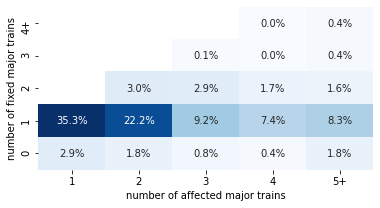

In [31]:
data = (df_major
        [['id','affected','fixed']]
        .groupby(['id'])
        .agg({
            'affected':'sum',
            'fixed':'sum'
        })
        .assign(affected=lambda d: d['affected'].where(d['affected'] < 5, '5+'),
             fixed=lambda d: d['fixed'].astype(str).where(d['fixed'] < 4, '4+'))
        .reset_index()
        .groupby(['affected', 'fixed'], as_index=False)
        .agg({'id': 'count'})
        .pivot(index='affected', columns='fixed', values='id')
        .div(df_major.id.unique().size)
        .T
        .fillna({4:0.0})
        .sort_index(ascending=False)
        )

fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=data,
    vmin=0, 
    vmax=0.25, 
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of affected major trains',
    ylabel='number of fixed major trains',
)

#savefig(fig, 'affected_fixed_majors')

In [33]:
data = (df_major
        .assign(fixed = lambda d: d['has_fix'])
        [['id','affected','fixed']]
        .groupby(['id'])
        .agg({
            'affected':'sum',
            'fixed':'sum'
        })
        .assign(affected=lambda d: d['affected'].where(d['affected'] < 5, 5),
             fixed=lambda d: d['fixed'].where(d['fixed'] < 5, 5))
        .reset_index()
       )

#### Let's check the type of updates having the fixes


In [34]:
(pandas
 .concat(
     [pandas.Series(row['id'], row['fix'].split('||'))
      for _, row in df_vuln.iterrows()])
 .reset_index()
 .rename(columns={'index':'version',0:'id'})
 .assign(filtering= lambda d: d['id'].isin(data.query('affected==1').id))
 .query('filtering')
 .merge(df_affected[['id','version','kind']],
       on = ['id','version'])
 .groupby('id')
 .agg({'kind':'min'})
 .reset_index()
 .query('kind != "major"')
 .groupby('kind')
 .count()
 .assign(prop= lambda d: d['id']*100/d['id'].sum())
)

,id,prop
kind,,
minor,62,22.962963
patch,208,77.037037


In [35]:
# Compute stats
df_stats= (
    df_major
    .groupby(['ecosystem', 'package','id'], as_index=False)
    .agg(
        number_of_fixes=('has_fix', 'sum'),
        number_of_fixed=('fixed', 'sum'),
        number_of_affected=('affected', 'sum'),
    )
    .eval("""
    fixed_by_next_major = number_of_fixes == 1 and number_of_fixed == 0
    fixed_in_current_major = number_of_fixes == 1 and number_of_fixed == 1
    fixed_with_backport = number_of_fixes > 1
    """)
)

In [36]:
df_stats.id.unique().size, df_stats.query('number_of_fixes>1').id.unique().size

(834, 94)

In [37]:
(
    df_stats
    .assign(strategy=lambda d: d[['fixed_by_next_major', 'fixed_in_current_major', 'fixed_with_backport']].idxmax(axis=1))
    .groupby(['ecosystem', 'strategy'])
    .agg(
        vulnerabilities=('id', 'nunique'),
        packages=('package', 'nunique'), 
    )
    .pipe(lambda df:
        pandas.concat([
            df, 
            df
            .groupby(['ecosystem'])
            .apply(lambda g: g / g.sum())           
            .rename(columns=lambda s: 'prop_{}'.format(s))
        ], axis=1)
    )
    .style
    .format('{:.1%}', subset=['prop_vulnerabilities', 'prop_packages',])
    .background_gradient(vmin=0, vmax=1, subset=['prop_vulnerabilities', 'prop_packages',])
)


## Let's look at the number of fixed/affected branches per package:

In [38]:
(
    df_major
    .groupby(['ecosystem', 'id', 'package'], as_index=False)
    .agg({
        'major': 'count',
        'affected': 'sum', 
        'has_fix': 'sum',
        'fixed': 'sum',
        'notfixed': 'sum',
    })
    .eval("""
    p_affected = affected / major
    p_fixed = fixed / affected
    p_notfixed = notfixed / affected
    """)
    .groupby('ecosystem')
    .describe()
    [['major', 'affected', 'fixed', 'has_fix', 'p_affected', 'p_fixed', 'p_notfixed']]
    .loc[:, (slice(None), ['mean', '50%'])]    
)

major       affected          fixed        has_fix       \
               mean  50%      mean  50%      mean  50%      mean  50%   
ecosystem                                                               
NPM        4.417745  3.0  2.543438  2.0  0.990758  1.0  1.092421  1.0   
Rubygems   4.180887  4.0  2.218430  2.0  1.126280  1.0  1.218430  1.0   

          p_affected             p_fixed      p_notfixed       
                mean       50%      mean  50%       mean  50%  
ecosystem                                                      
NPM         0.722615  0.833333  0.577476  0.5   0.422524  0.5  
Rubygems    0.620795  0.571429  0.634585  0.5   0.365415  0.5

# Affected dependent packages

It would be interesting to see how many dependent packages are still affected by each vulnerability. We expect this number to be lower for packages having backported a security fix. 
However, some vulnerabilities are old(er), and some of them affect (very) old versions, implying that any comparison would be biased. Moreover, some dependent packages could have been abandoned, hence not adopting a newer version (fixed or not) anyway. Finally, we only have the dependencies for the latest snapshot, hence we will simply count the (absolute) number of dependent packages that: 

 - are still relying on an older major branch affected by the vulnerability, and not fixed;
 - are still relying on an older major branch affected by the vulnerability, and fixed (i.e., they benefit from the backported fix).

In [39]:
df_dependents[df_dependents.target.isin(df_major.package)].target.unique().size

381

In [40]:
df_aff_dep = (
    df_major
    # Get latest major
    .merge(
        df_major
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg(latest_major=('major', 'max')),
        how='inner',
        on=['ecosystem', 'package'],
    )
    # Get latest fix to identify backports
    .merge(
        df_major
        .query('has_fix')
        .groupby(['ecosystem', 'package','id'], as_index=False)
        .agg(latest_fixed_major=('major', 'max')),
        how='inner', 
        on=['ecosystem', 'package','id'],
    )
    # Merge dependents
    .merge(
        df_dependents[['ecosystem', 'source', 'target', 'selected']],
        how='inner',
        left_on=['ecosystem', 'package'],
        right_on=['ecosystem', 'target'],
    )
    # Keep selected major
    .query('minrank <= selected <= maxrank')
    .eval('backported = fixed and latest_fixed_major > major')
)

### How many packages depend on the vulnerable ones?

In [41]:
(
    df_aff_dep
    .groupby('ecosystem')
    .agg(
        vulnerabilities=('id', 'nunique'),
        required=('package', 'nunique'), 
        source=('source', 'nunique'),
        dependencies=('source', 'count')
    ) 
)

,vulnerabilities,required,source,dependencies
ecosystem,,,,
NPM,541,292,108008,513714
Rubygems,293,91,7234,74786


In [42]:
df_aff_dep.query('ecosystem=="NPM"').package.unique().size

292

In [43]:
df_aff_dep.id.unique().size

834

### How many packages depend on an affected major branch? 

Remember that it is not meaningful to look at these numbers proportionally to the above ones!

In [44]:
(
    df_aff_dep
    .query('affected')
    .groupby('ecosystem')
    .agg(
        vulnerabilities=('id', 'nunique'),
        required=('package', 'nunique'), 
        source=('source', 'nunique'),
        dependencies=('source', 'count')
    ) 
)

,vulnerabilities,required,source,dependencies
ecosystem,,,,
NPM,493,271,93725,386005
Rubygems,222,73,3677,21271


### How many of these packages depend on a previous (affected) major branch? 

Remember that it is not meaningful to look at these numbers proportionally to the above ones!

In [45]:
len(df_aff_dep.query('affected and major < latest_fixed_major'))

11729

In [46]:
df_aff_dep_filter = df_aff_dep.query('affected and major < latest_fixed_major')

In [47]:
(
    df_aff_dep_filter
    .groupby('ecosystem')
    .agg(
        vulnerabilities=('id', 'nunique'),
        required=('package', 'nunique'), 
        source=('source', 'nunique'),
        dependencies=('source', 'count')
    ) 
)

,vulnerabilities,required,source,dependencies
ecosystem,,,,
NPM,227,127,6034,11335
Rubygems,52,23,240,394


In [48]:
# Number of dependencies
len(df_aff_dep_filter
    [['ecosystem','source','package','major','id']]
    .drop_duplicates()
   )

11729

In [49]:
len(df_aff_dep.query('affected')[['ecosystem','package','major']].drop_duplicates())

575

In [50]:
# Number of majors
len(df_aff_dep_filter
    [['ecosystem','package','major']]
    .drop_duplicates()
   )

261

In [51]:
# Number of majors with vulns
len(df_aff_dep_filter
    [['ecosystem','package','major','id']]
    .drop_duplicates()
   )

438

In [52]:
# Majors with no fix
len(df_aff_dep_filter
    .query('not fixed')
    [['ecosystem','package','major','id']]
    .drop_duplicates()
   )

368

### How many dependent packages benefit from a backport?

These numbers can be compared with the above ones. 

In [53]:
# Number fixed dependencies
len(
    df_aff_dep_filter
    .query('not fixed')
    [['ecosystem','source','target']]
    .drop_duplicates()
)

5585

In [54]:
# Number of dependecies
(
    df_aff_dep_filter
    .query('fixed')
    .groupby('ecosystem')
    .agg(
        vulnerabilities=('id', 'nunique'),
        required=('package', 'nunique'), 
        source=('source', 'nunique'),
        dependencies=('source', 'count')
    )
)

,vulnerabilities,required,source,dependencies
ecosystem,,,,
NPM,31,24,1938,3145
Rubygems,25,8,94,166


### How many dependent packages would benefit from a backport? 

These numbers can be compared with the ones above the above ones. 

In [55]:
(
    df_aff_dep_filter
    .query('not fixed')
    .groupby('ecosystem')
    .agg(
        vulnerabilities=('id', 'nunique'),
        required=('package', 'nunique'), 
        source=('source', 'nunique'),
        dependencies=('source', 'count')
    )
)

,vulnerabilities,required,source,dependencies
ecosystem,,,,
NPM,205,117,4884,8190
Rubygems,29,18,166,228


Putting everything together: 

In [56]:
(
    df_aff_dep
    .eval('on_latest_major = major == latest_major')
    [['ecosystem', 'id', 'package', 'source', 'backported', 'affected', 'fixed', 'on_latest_major']]
    .groupby(['ecosystem', 'on_latest_major', 'affected', 'fixed', 'backported'])
    .agg(
        vulnerabilities=('id', 'nunique'),
        required=('package', 'nunique'), 
        source=('source', 'nunique'),
        cases=('source', 'count')
    )
)

vulnerabilities  \
ecosystem on_latest_major affected fixed backported                    
NPM       False           False    False False                   165   
                          True     False False                   205   
                                   True  False                   166   
                                         True                     31   
          True            False    False False                   263   
                          True     True  False                   276   
Rubygems  False           False    False False                   130   
                          True     False False                    29   
                                   True  False                   115   
                                         True                     25   
          True            False    False False                   204   
                          True     False False                     1   
                                   True  False                    88   

                                                     required  source   cases  
ecosystem on_latest_major affected fixed backported                            
NPM       False           False    False False             87   14221   36274  
                          True     False False            117    4884    8190  
                                   True  False            102    8787   17000  
                                         True              24    1938    3145  
          True            False    False False            149   40819   91435  
                          True     True  False            163   88109  357670  
Rubygems  False           False    False False             27    1242   11806  
                          True     False False             18     166     228  
                                   True  False             33     538    1737  
                                         True               8      94     166  
          True            False    False False             60    4712   41709  
                          True     False False              1       7       7  
                                   True  False             43    3203   19133

# Let's check just two examples, one with backport and the other one without

In [57]:
example_both = df_aff_dep.query('id == "SNYK-JS-BOOTSTRAP-11109" or id == "SNYK-JS-LODASH-450202"')

In [58]:
(example_both[['id','source','package','major','fixed','backported']]
 .groupby('id')
 .agg({
     'source':'nunique',
     'package':'unique',
     'major':'nunique',
     'fixed':'sum',
     'backported':'sum',
 })
 .reset_index()
)

,id,source,package,major,fixed,backported
0,SNYK-JS-BOOTSTRAP-11109,2384,[bootstrap],2,2384,373
1,SNYK-JS-LODASH-450202,26073,[lodash],5,25672,0
